In [3]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data 
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.backends.cudnn.deterministic = True

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

model = nn.Sequential(
    nn.Conv2d(3,6,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    
    nn.Linear(16*5*5, 120),
    nn.ReLU(),
    
    nn.Linear(120, 84),
    nn.ReLU(),
    
    nn.Linear(84,10)
)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
#Transformations
train_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ])

test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

#Creating the Datasets
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform= transforms.ToTensor())
valset = datasets.CIFAR10(root = './data', train = False, download = True, transform = test_transforms)


#Data Loaders
batch_size = 2500
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                        shuffle=True, pin_memory=True)

valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle = True, pin_memory = True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
def trainNetwork(model, lossfunc, trainloader, valloader = None, scorefuncs = None, epochs = 100, device = "cuda:0", checkpoint_file = None):
    
    #Model -> the model to train
    # Loss function -> the lost function that takes in two arguemnts, the model outputs and the labels and returns a score
    # Train loader -> the PyTorch DataLoader object
    # valloader -> an optional DataLoader for validation after every epoch
    # scorefuncs -> dictionary of scoring functions to evaluate the performance
    # epochs -> number of epochs to perform
    #device -> the location of which to perform computation
    
    tracking = ["epoch", "total time", "train loss", "total correct"]
    if valloader is not None:
        tracking.append("val loss")
        
    for evalscore in scorefuncs.keys():
        tracking.append("train " + evalscore)
        if valloader is not None:
            tracking.append("val " + evalscore)
            
    totaltraintime = 0 # The time spent in the training loop
    results = {}
    
    #initialising every item with an empty list
    for item in tracking:
        results[item] = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas= (0.9, 0.999), eps = 1e-08, weight_decay=0)
    
    model.to(device)
    
    for epoch in range(epochs):
        model = model.train()
        total_correct = 0
        total_loss = 0.0
        
        y_true = []
        y_pred = []
        start = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            for param in model.parameters():
                param.grad = None
            
            output = model(inputs).to(device)
            loss = lossfunc(output, labels)
            
            loss.backward()
            
            optimizer.step()
            total_loss += loss.item()
            total_correct += output.argmax(dim=1).eq(labels).sum().item()
            
            labels = labels.detach().cpu().numpy()
            output = output.detach().cpu().numpy()
            
            for i in range(inputs.shape[0]):
                y_true.append(labels[i])
                y_pred.append(output[i,:])
        end = time.time()
        totaltraintime += (end-start)
        
        results["epoch"].append(epoch)
        results["total time"].append(totaltraintime)
        results["train loss"].append(total_loss)
        results["total correct"].append(total_correct)
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] >1:
            y_pred = np.argmax(y_pred, axis = 1)
            
        for name, scorefunc in scorefuncs.items():
            results["train " + name].append( scorefunc(y_true, y_pred) )
            
        if valloader is None:
            pass
        else:
            #validation performance
            model = model.eval() #setting to evaluation  mode
            y_true = []
            y_pred = []
            total_loss = 0.0
            total_correct = 0
            
            for inputs, labels in valloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                
                output = model(inputs).to(device)
                
                loss = lossfunc(output, labels)
                
                total_loss += loss.item()
                total_correct += output.argmax(dim=1).eq(labels).sum().item()
                
                labels = labels.detach().cpu().numpy()
                output = output.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(output[i,:])
                
            results["val loss"].append(total_loss)
            y_pred = np.asarray(y_pred)
            
            if y_pred.shape[1] >1:
                y_pred = np.argmax(y_pred, axis =1)
                
            for name, scorefunc in scorefuncs.items():
                results["val " + name].append( scorefunc(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch' : epoch,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results,
            }, checkpoint_file)    
    
    return pd.DataFrame.from_dict(results)

In [9]:
def trainNetworkAdamax(model, lossfunc, trainloader, valloader = None, scorefuncs = None, epochs = 100, device = "cuda:0", checkpoint_file = None):
    
    #Model -> the model to train
    # Loss function -> the lost function that takes in two arguemnts, the model outputs and the labels and returns a score
    # Train loader -> the PyTorch DataLoader object
    # valloader -> an optional DataLoader for validation after every epoch
    # scorefuncs -> dictionary of scoring functions to evaluate the performance
    # epochs -> number of epochs to perform
    #device -> the location of which to perform computation
    
    tracking = ["epoch", "total time", "train loss", "total correct"]
    if valloader is not None:
        tracking.append("val loss")
        
    for evalscore in scorefuncs.keys():
        tracking.append("train " + evalscore)
        if valloader is not None:
            tracking.append("val " + evalscore)
            
    totaltraintime = 0 # The time spent in the training loop
    results = {}
    
    #initialising every item with an empty list
    for item in tracking:
        results[item] = []
    
    optimizer = torch.optim.Adamax(model.parameters(), lr = 0.001, betas= (0.9, 0.999), eps = 1e-08, weight_decay=0)
    
    model.to(device)
    
    for epoch in range(epochs):
        model = model.train()
        total_correct = 0
        total_loss = 0.0
        
        y_true = []
        y_pred = []
        start = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            for param in model.parameters():
                param.grad = None
            
            output = model(inputs).to(device)
            loss = lossfunc(output, labels)
            
            loss.backward()
            
            optimizer.step()
            total_loss += loss.item()
            total_correct += output.argmax(dim=1).eq(labels).sum().item()
            
            labels = labels.detach().cpu().numpy()
            output = output.detach().cpu().numpy()
            
            for i in range(inputs.shape[0]):
                y_true.append(labels[i])
                y_pred.append(output[i,:])
        end = time.time()
        totaltraintime += (end-start)
        
        results["epoch"].append(epoch)
        results["total time"].append(totaltraintime)
        results["train loss"].append(total_loss)
        results["total correct"].append(total_correct)
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] >1:
            y_pred = np.argmax(y_pred, axis = 1)
            
        for name, scorefunc in scorefuncs.items():
            results["train " + name].append( scorefunc(y_true, y_pred) )
            
        if valloader is None:
            pass
        else:
            #validation performance
            model = model.eval() #setting to evaluation  mode
            y_true = []
            y_pred = []
            
            total_loss = 0.0
            total_correct = 0
            
            for inputs, labels in valloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                
                output = model(inputs).to(device)
                
                loss = lossfunc(output, labels)
                
                total_loss += loss.item()
                total_correct += output.argmax(dim=1).eq(labels).sum().item()
                
                labels = labels.detach().cpu().numpy()
                output = output.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(output[i,:])
                
            results["val loss"].append(total_loss)
            y_pred = np.asarray(y_pred)
            
            if y_pred.shape[1] >1:
                y_pred = np.argmax(y_pred, axis =1)
                
            for name, scorefunc in scorefuncs.items():
                results["val " + name].append( scorefunc(y_true, y_pred) )
        if checkpoint_file is not None:
            torch.save({
                'epoch' : epoch,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results 
            }, checkpoint_file)    
    
    return pd.DataFrame.from_dict(results)

In [10]:
def trainNetworkSGD(model, lossfunc, trainloader, valloader = None, scorefuncs = None, epochs = 100, device = "cuda:0", checkpoint_file = None):
    
    #Model -> the model to train
    # Loss function -> the lost function that takes in two arguemnts, the model outputs and the labels and returns a score
    # Train loader -> the PyTorch DataLoader object
    # valloader -> an optional DataLoader for validation after every epoch
    # scorefuncs -> dictionary of scoring functions to evaluate the performance
    # epochs -> number of epochs to perform
    #device -> the location of which to perform computation
    
    tracking = ["epoch", "total time", "train loss", "total correct"]
    if valloader is not None:
        tracking.append("val loss")
        
    for evalscore in scorefuncs.keys():
        tracking.append("train " + evalscore)
        if valloader is not None:
            tracking.append("val " + evalscore)
            
    totaltraintime = 0 # The time spent in the training loop
    results = {}
    
    #initialising every item with an empty list
    for item in tracking:
        results[item] = []
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
    
    model.to(device)
    
    for epoch in range(epochs):
        model = model.train()
        total_correct = 0
        total_loss = 0.0
        
        y_true = []
        y_pred = []
        start = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            for param in model.parameters():
                param.grad = None
            
            output = model(inputs).to(device)
            loss = lossfunc(output, labels)
            
            loss.backward()
            
            optimizer.step()
            total_loss += loss.item()
            total_correct += output.argmax(dim=1).eq(labels).sum().item()
            
            labels = labels.detach().cpu().numpy()
            output = output.detach().cpu().numpy()
            
            for i in range(inputs.shape[0]):
                y_true.append(labels[i])
                y_pred.append(output[i,:])
        end = time.time()
        totaltraintime += (end-start)
        
        results["epoch"].append(epoch)
        results["total time"].append(totaltraintime)
        results["train loss"].append(total_loss)
        results["total correct"].append(total_correct)
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] >1:
            y_pred = np.argmax(y_pred, axis = 1)
            
        for name, scorefunc in scorefuncs.items():
            results["train " + name].append( scorefunc(y_true, y_pred) )
            
        if valloader is None:
            pass
        else:
            #validation performance
            model = model.eval() #setting to evaluation  mode
            y_true = []
            y_pred = []
            
            total_loss = 0.0
            total_correct = 0
            
            for inputs, labels in valloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                
                output = model(inputs).to(device)
                
                loss = lossfunc(output, labels)
                
                total_loss += loss.item()
                total_correct += output.argmax(dim=1).eq(labels).sum().item()
                
                labels = labels.detach().cpu().numpy()
                output = output.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(output[i,:])
                
            results["val loss"].append(total_loss)
            y_pred = np.asarray(y_pred)
            
            if y_pred.shape[1] >1:
                y_pred = np.argmax(y_pred, axis =1)
                
            for name, scorefunc in scorefuncs.items():
                results["val " + name].append( scorefunc(y_true, y_pred) )
        if checkpoint_file is not None:
            torch.save({
                'epoch' : epoch,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results ,
                'y_pred' : y_pred
            }, checkpoint_file)    
    
    return pd.DataFrame.from_dict(results)

In [11]:
lossfunc = nn.CrossEntropyLoss()
model1Results= trainNetwork(model, lossfunc =lossfunc, trainloader =trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=10)

<Axes: xlabel='epoch', ylabel='train accuracy'>

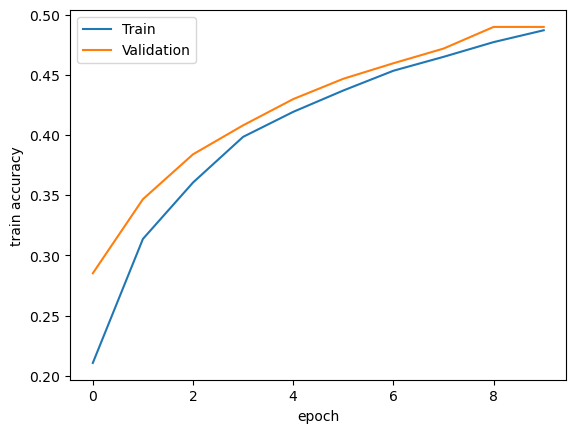

In [12]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation')

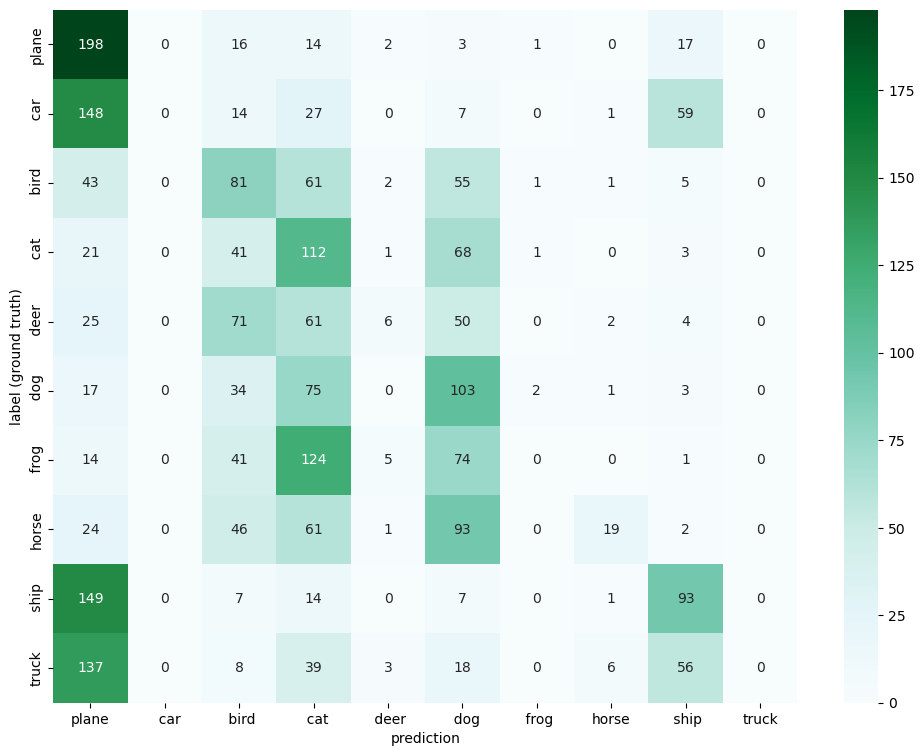

In [13]:
with torch.no_grad():
    correct =0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        y_val = model(images)
        predicted = torch.max(y_val,1)[1]
# Display the confusion matrix as a heatmap
arr = confusion_matrix(labels.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [14]:
model = nn.Sequential(
    nn.Conv2d(3,6,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    
    nn.Linear(16*5*5, 120),
    nn.ReLU(),
    
    nn.Linear(120, 84),
    nn.ReLU(),
    
    nn.Linear(84,10)
)

In [15]:
lossfunc = nn.CrossEntropyLoss()
model1ResultAdamax = trainNetworkAdamax(model, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=10)

<Axes: xlabel='epoch', ylabel='train accuracy'>

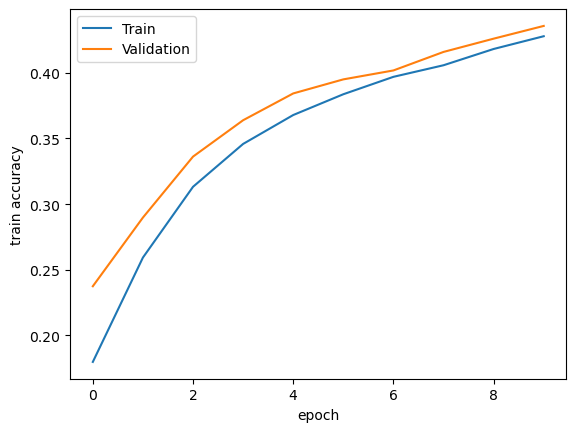

In [16]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultAdamax, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultAdamax, label = 'Validation')

Test accuracy: 1974/10000 =  19.740%


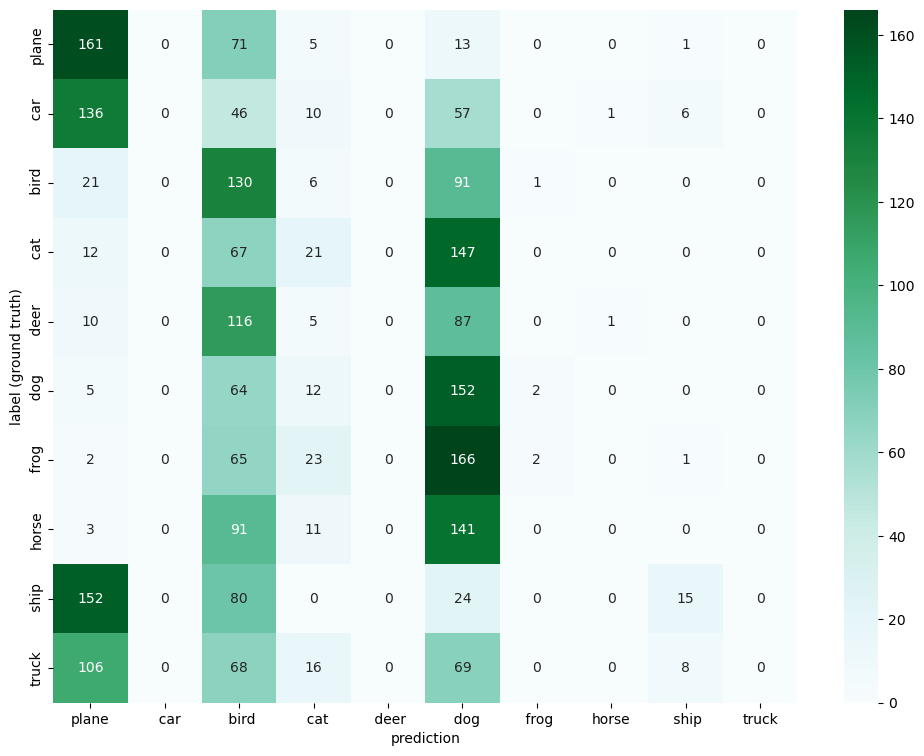

In [17]:
with torch.no_grad():
    correct =0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        y_val = model(images)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == labels).sum()
        
print(f'Test accuracy: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')
# Display the confusion matrix as a heatmap
arr = confusion_matrix(labels.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [18]:
model = nn.Sequential(
    nn.Conv2d(3,6,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    
    nn.Linear(16*5*5, 120),
    nn.ReLU(),
    
    nn.Linear(120, 84),
    nn.ReLU(),
    
    nn.Linear(84,10)
)

In [19]:
lossfunc = nn.CrossEntropyLoss()
model1ResultSGD = trainNetworkSGD(model, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=10)

<Axes: xlabel='epoch', ylabel='train accuracy'>

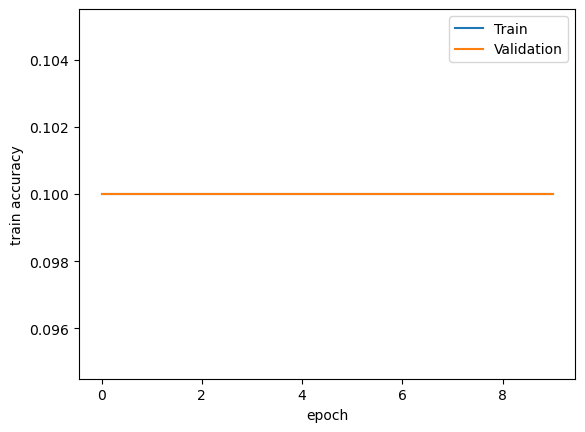

In [20]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultSGD, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultSGD, label = 'Validation')

Test accuracy: 1000/10000 =  10.000%


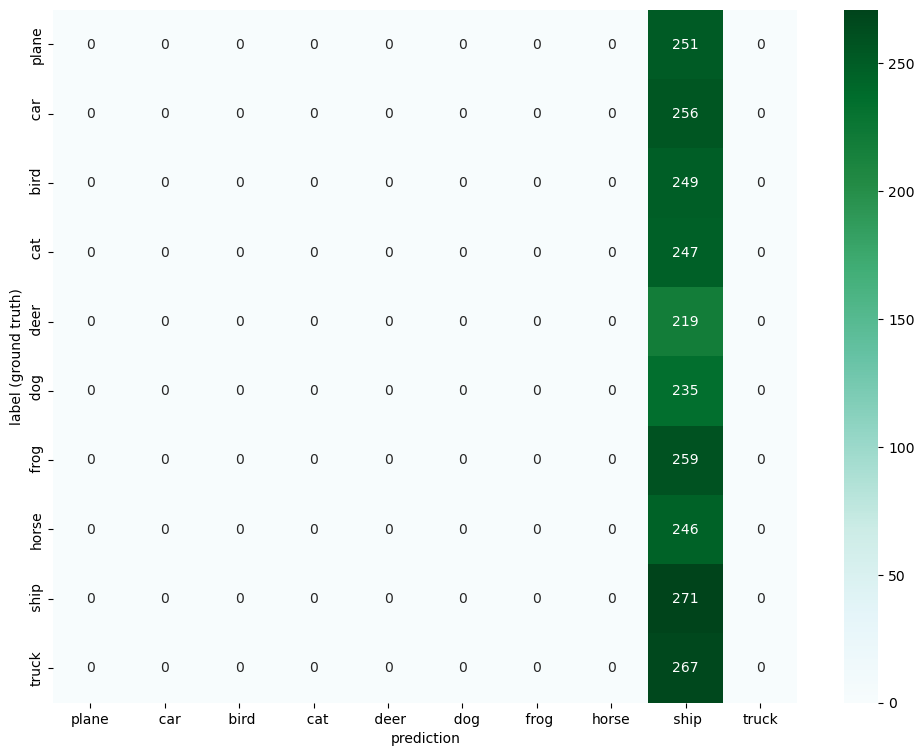

In [21]:
with torch.no_grad():
    correct =0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        y_val = model(images)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == labels).sum()
        
print(f'Test accuracy: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')
# Display the confusion matrix as a heatmap
arr = confusion_matrix(labels.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

<Axes: xlabel='epoch', ylabel='train accuracy'>

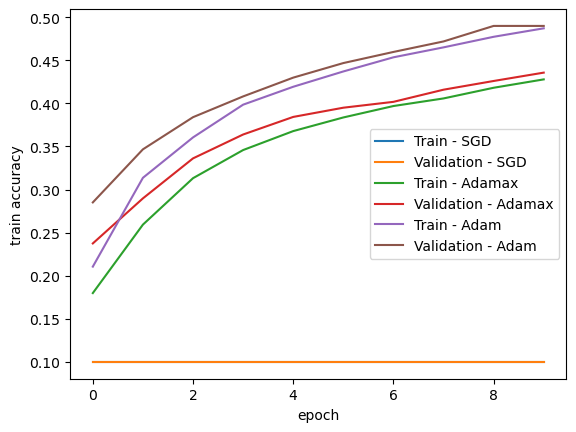

In [22]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultSGD, label = 'Train - SGD')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultSGD, label = 'Validation - SGD')
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultAdamax, label = 'Train - Adamax')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultAdamax, label = 'Validation - Adamax')
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train - Adam')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation - Adam')

In [23]:
model = nn.Sequential(
    nn.Conv2d(3,6,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    
    nn.Linear(16*5*5, 120),
    nn.ReLU(),
    
    nn.Linear(120, 84),
    nn.ReLU(),
    
    nn.Linear(84,10)
)

In [24]:
lossfunc = nn.CrossEntropyLoss()
model1Results = trainNetwork(model, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)
print(model1Results)

    epoch  total time  train loss  total correct  val loss  train accuracy  \
0       0   10.572998   43.812112           9734  8.073967         0.19468   
1       1   21.130499   38.494246          15403  7.342344         0.30806   
2       2   31.664500   35.737526          17709  6.863644         0.35418   
3       3   42.306501   33.568780          19775  6.550940         0.39550   
4       4   52.877502   32.204419          21000  6.310024         0.42000   
5       5   63.412503   31.240655          21834  6.139417         0.43668   
6       6   74.115503   30.460007          22588  6.027465         0.45176   
7       7   84.949504   29.897848          23101  5.906154         0.46202   
8       8   95.838507   29.322284          23764  5.833860         0.47528   
9       9  106.691008   28.981834          24105  5.776412         0.48210   
10     10  117.612009   28.729313          24219  5.745880         0.48438   
11     11  128.347007   28.329177          24603  5.640249      

<Axes: xlabel='epoch', ylabel='train accuracy'>

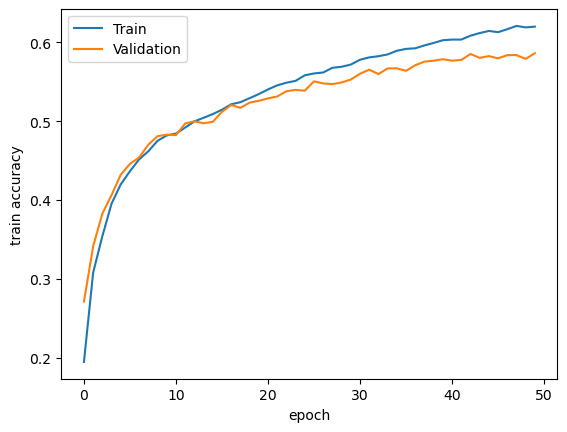

In [25]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation')

Test accuracy: 2460/10000 =  24.600%


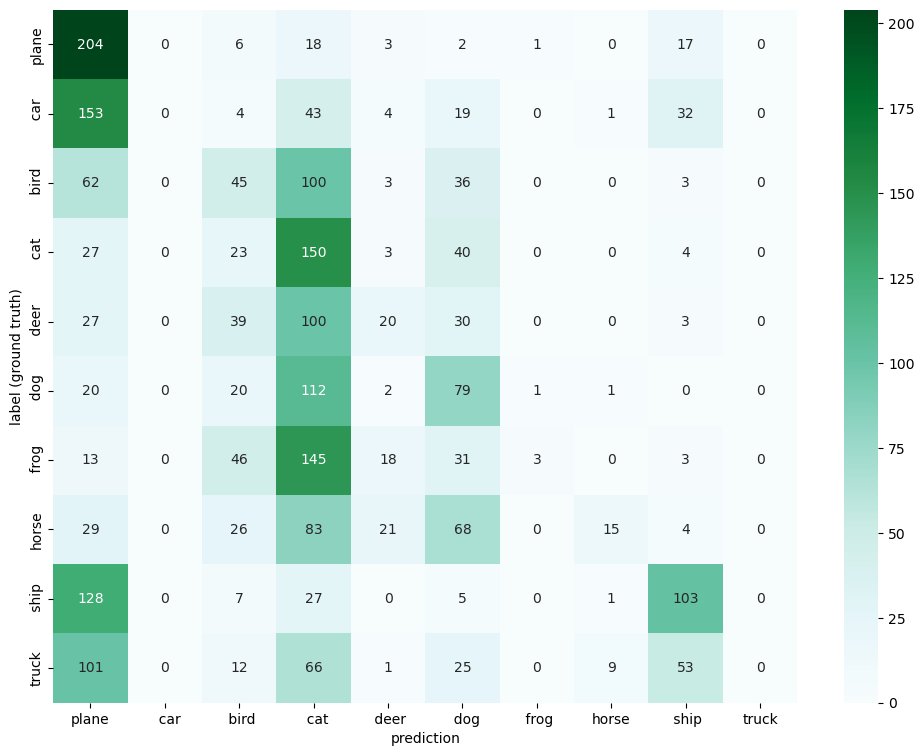

In [26]:
with torch.no_grad():
    correct =0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        y_val = model(images)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == labels).sum()
        
print(f'Test accuracy: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')
# Display the confusion matrix as a heatmap
arr = confusion_matrix(labels.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [27]:
model = nn.Sequential(
    nn.Conv2d(3,6,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    
    nn.Linear(16*5*5, 120),
    nn.ReLU(),
    
    nn.Linear(120, 84),
    nn.ReLU(),
    
    nn.Linear(84,10)
)

In [28]:
lossfunc = nn.CrossEntropyLoss()
model1ResultsAdaMax = trainNetworkAdamax(model,lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)

<Axes: xlabel='epoch', ylabel='train accuracy'>

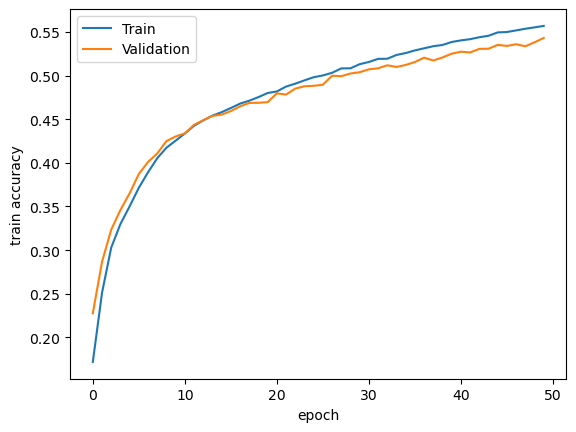

In [29]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultsAdaMax, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultsAdaMax, label = 'Validation')

Test accuracy: 2245/10000 =  22.450%


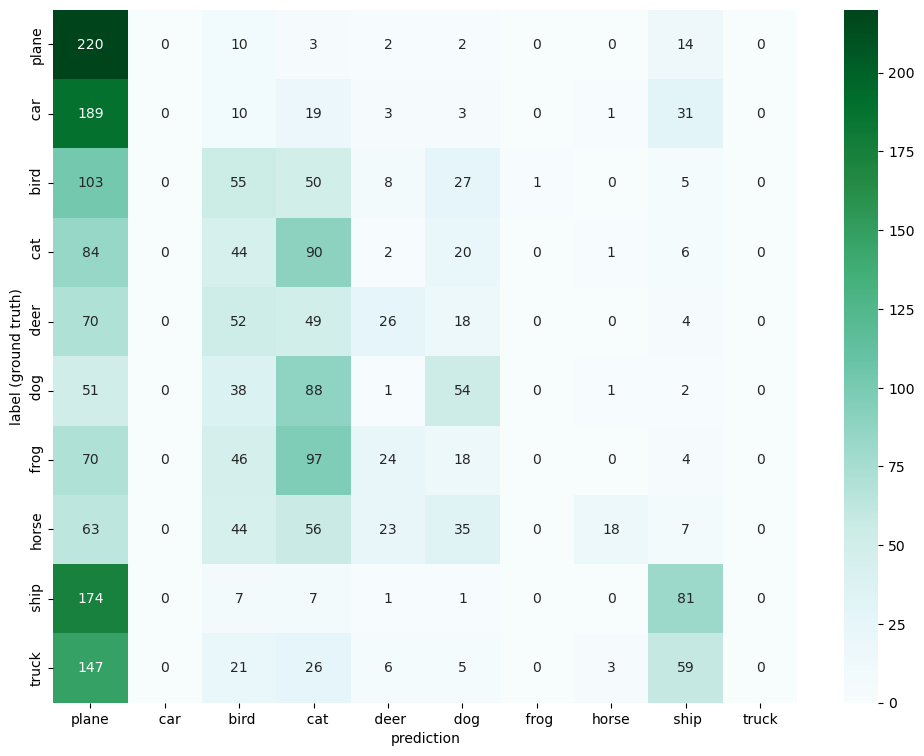

In [30]:
with torch.no_grad():
    correct =0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        y_val = model(images)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == labels).sum()
        
print(f'Test accuracy: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')
# Display the confusion matrix as a heatmap
arr = confusion_matrix(labels.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [31]:
model = nn.Sequential(
    nn.Conv2d(3,6,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    
    nn.Linear(16*5*5, 120),
    nn.ReLU(),
    
    nn.Linear(120, 84),
    nn.ReLU(),
    
    nn.Linear(84,10)
)

In [32]:
lossfunc = nn.CrossEntropyLoss()
model1ResultSGD = trainNetworkSGD(model, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)

<Axes: xlabel='epoch', ylabel='train accuracy'>

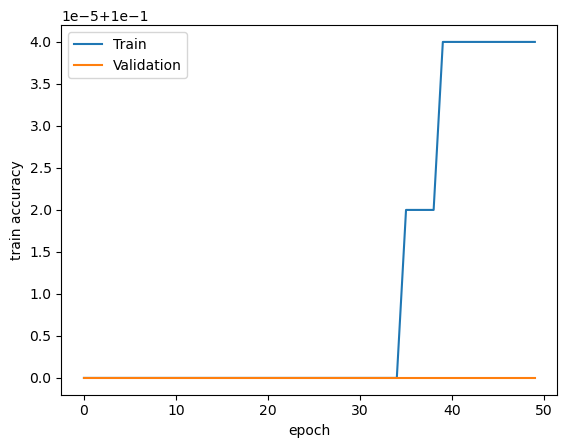

In [33]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultSGD, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultSGD, label = 'Validation')

Test accuracy: 1000/10000 =  10.000%


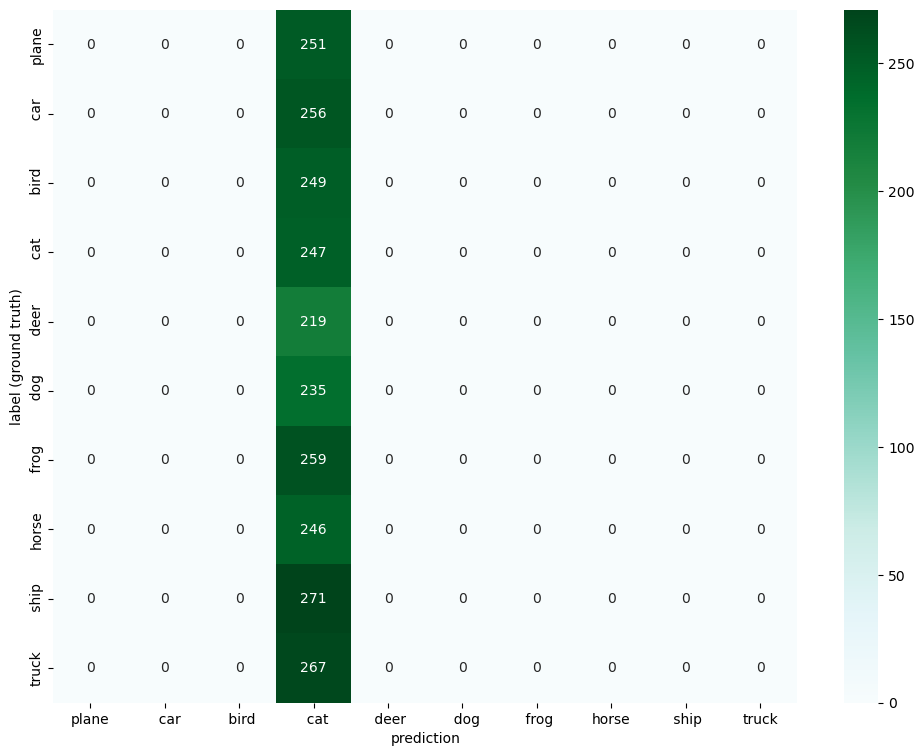

In [34]:
with torch.no_grad():
    correct =0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        y_val = model(images)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == labels).sum()
        
print(f'Test accuracy: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')
# Display the confusion matrix as a heatmap
arr = confusion_matrix(labels.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

<Axes: xlabel='epoch', ylabel='train accuracy'>

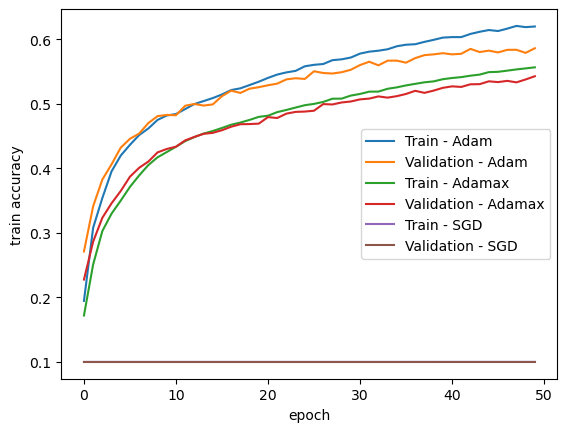

In [35]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train - Adam')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation - Adam')
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultsAdaMax, label = 'Train - Adamax')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultsAdaMax, label = 'Validation - Adamax')
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultSGD, label = 'Train - SGD')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultSGD, label = 'Validation - SGD')

In [36]:
model = nn.Sequential(
    nn.Conv2d(3,6,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    
    nn.Linear(16*5*5, 120),
    nn.ReLU(),
    
    nn.Linear(120, 84),
    nn.ReLU(),
    
    nn.Linear(84,10)
)

In [37]:
lossfunc = nn.CrossEntropyLoss()
model1Results = trainNetwork(model, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=100)

<Axes: xlabel='epoch', ylabel='train accuracy'>

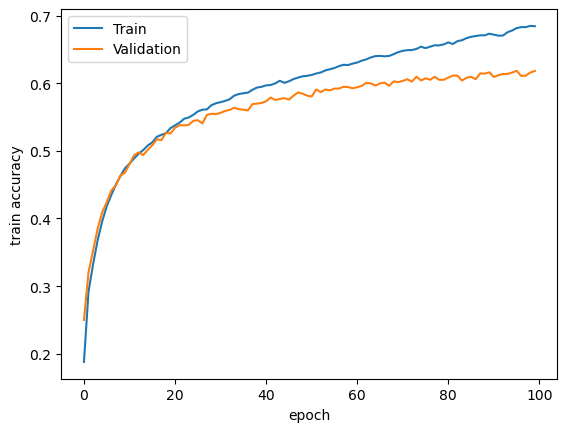

In [38]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation')

Test accuracy: 2926/10000 =  29.260%


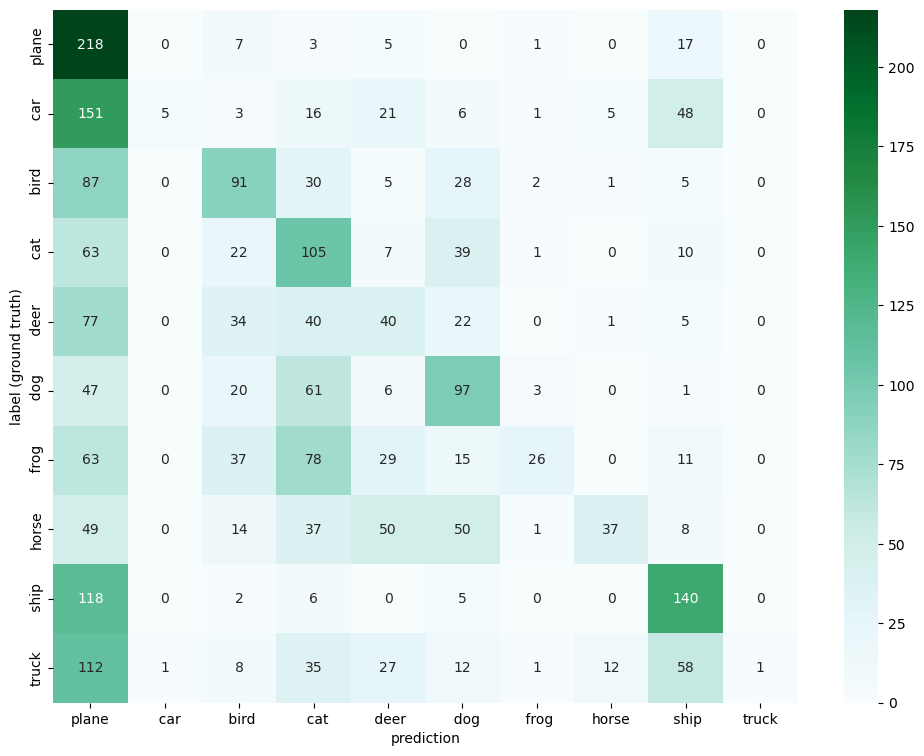

In [39]:
with torch.no_grad():
    correct =0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        y_val = model(images)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == labels).sum()
        
print(f'Test accuracy: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')
# Display the confusion matrix as a heatmap
arr = confusion_matrix(labels.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [47]:
model = nn.Sequential(
    nn.Conv2d(3,6,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    Flatten(),
    
    nn.Linear(16*5*5, 120),
    nn.ReLU(),
    
    nn.Linear(120, 84),
    nn.ReLU(),
    
    nn.Linear(84,10)
)

In [50]:
lossfunc = nn.CrossEntropyLoss()
model1EditedResults = trainNetwork(model, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=100)

<Axes: xlabel='epoch', ylabel='train accuracy'>

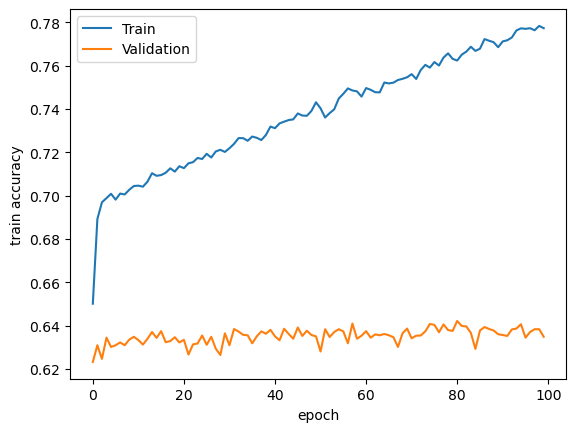

In [73]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1EditedResults, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1EditedResults, label = 'Validation')

Test accuracy: 2926/10000 =  29.260%


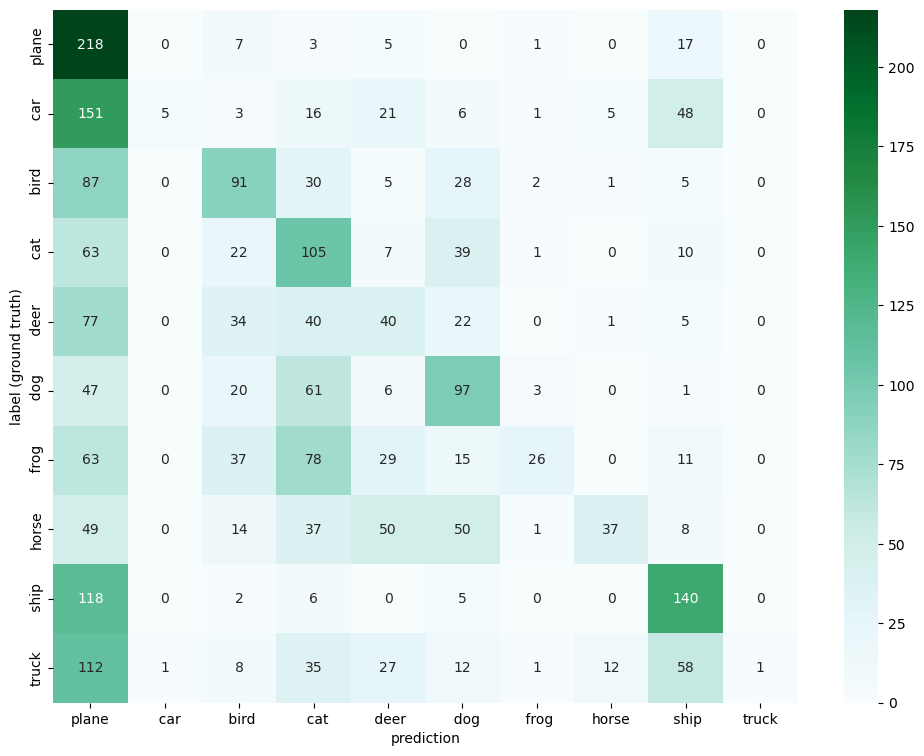

In [ ]:
with torch.no_grad():
    correct =0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        y_val = model(images)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == labels).sum()
        
print(f'Test accuracy: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')
# Display the confusion matrix as a heatmap
arr = confusion_matrix(labels.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [71]:
model = nn.Sequential(
    nn.Conv2d(3,32,3, padding =1),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),
    
    nn.Conv2d(32,32,3, padding = 1),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),
    
    nn.Conv2d(32,64,3, padding = 1),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),
    
    nn.Conv2d(64,120,3, padding = 1),
    nn.MaxPool2d(kernel_size=3),
    nn.ReLU(),
    Flatten(),
    
    nn.Linear(120, 84),
    nn.ReLU(),
    
    nn.Linear(84,10),
)

In [72]:
lossfunc = nn.CrossEntropyLoss()
mymodelResults = trainNetwork(model, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=100)

<Axes: xlabel='epoch', ylabel='train accuracy'>

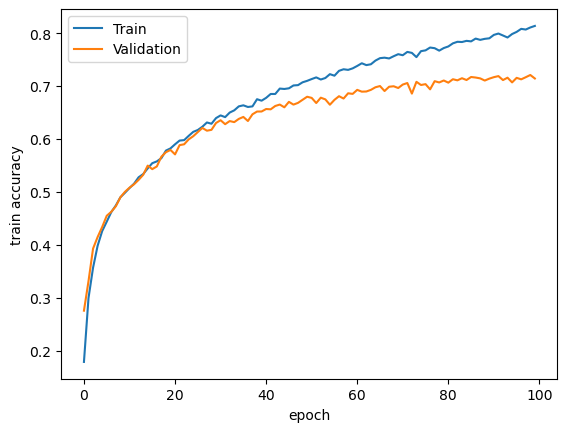

In [79]:
sns.lineplot(x='epoch', y ='train accuracy', data = mymodelResults, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = mymodelResults, label = 'Validation')

<Axes: xlabel='epoch', ylabel='train loss'>

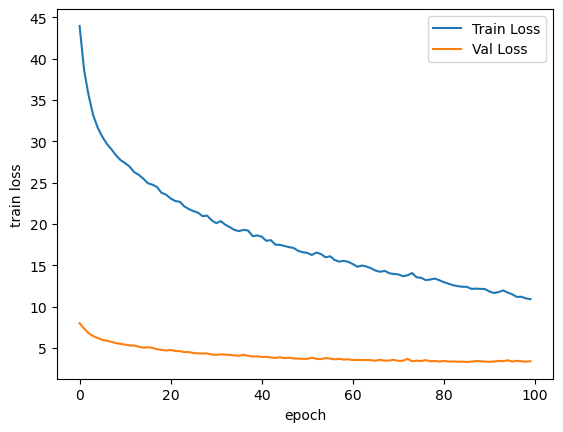

In [81]:
sns.lineplot(x='epoch', y ='train loss', data = mymodelResults, label = 'Train Loss')
sns.lineplot(x='epoch', y ='val loss', data = mymodelResults, label = 'Val Loss')

Test accuracy: 3962/10000 =  39.620%


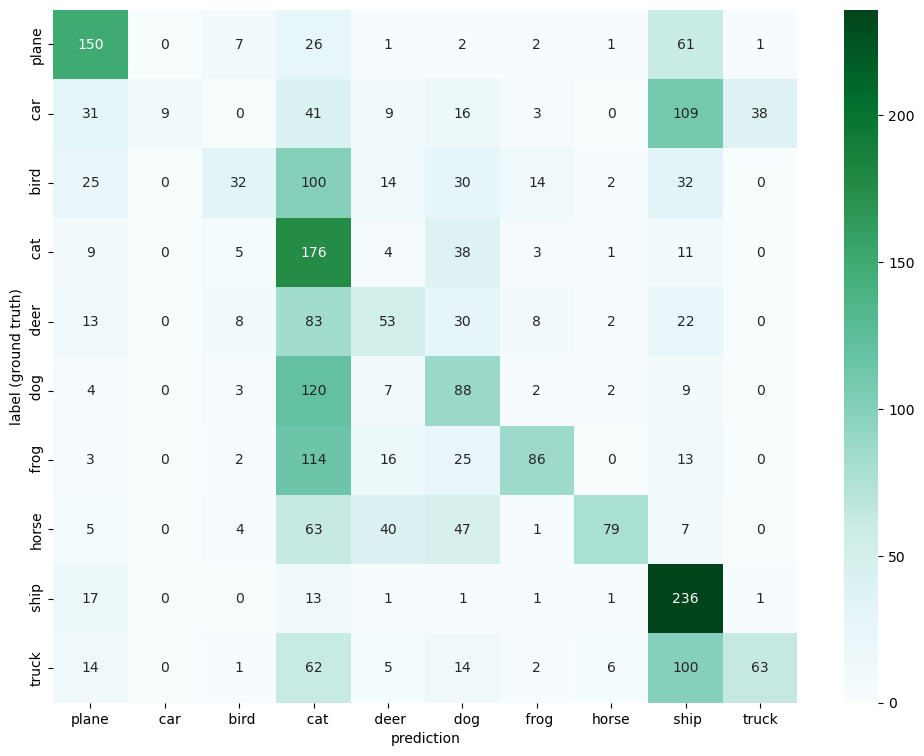

In [82]:
with torch.no_grad():
    correct =0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        y_val = model(images)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == labels).sum()
        
print(f'Test accuracy: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')
# Display the confusion matrix as a heatmap
arr = confusion_matrix(labels.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()